## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import HeatMap

from helpers import *

df = pd.read_csv("kc_house_data.csv")

## Data Cleaning

In [2]:
# Filling nulls in the View, Waterfront and Year Renovated columns
for col in ['view', 'waterfront', 'yr_renovated']:
        df[col] = df[col].fillna(0)

In [3]:
# Using sqft_living and sqft_above to fill null sqft_basement rows
df["sqft_basement"] = df.apply(replace_null_basement(df), axis = 1)

In [4]:
# Creating a Posix Date column
df['posix_date'] = df['date'].apply(lambda x: to_posix(x))

In [5]:
# Changing the Date column to be datetime objects
df['date'] = pd.to_datetime(df['date'])

In [6]:
# Changing the values in the Waterfront, View and Year Renovated columns
# to be integers instead of floats
for col in ['waterfront', 'view', 'yr_renovated']:
    df[col] = df[col].apply(lambda x: to_int(x))

In [7]:
# Removing an obvious, problematic outlier with 33 bedrooms
df = df[df['bedrooms']!=33]

## Data Overview

In [8]:
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,posix_date
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,1.413176e+09
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1.418105e+09
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,1.424844e+09
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1.418105e+09
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,1.424239e+09


#### Creating a Correlation Heatmap for our variables

In [9]:
# Creating a dataframe for the columns we'll be correlating (excluding ID and date)
df_corr = df.loc[:, "price":"posix_date"]

In [10]:
# Creating the correlation array, making it a dataframe, and renaming columns
map_corr = np.corrcoef(df_corr, rowvar=0)
map_corr = pd.DataFrame(map_corr,
                        columns=['Price', 'Bedrooms', 'Bathrooms', 'Living SqFt', 'Lot SqFt', 'Floors',
                                 'Waterfront', 'View', 'Condition', 'Grade', 'Above-Ground SqFt',
                                 'Basement SqFt', 'Year Built', 'Year Renovated', 'Zipcode', 'Lat', 'Long',
                                 'Neighbor Lv', 'Neighbor Lot', 'Date in Posix'],
                        index=['Price', 'Bedrooms', 'Bathrooms', 'Living SqFt', 'Lot SqFt', 'Floors',
                               'Waterfront', 'View', 'Condition', 'Grade', 'Above-Ground SqFt',
                               'Basement SqFt', 'Year Built', 'Year Renovated', 'Zipcode', 'Lat', 'Long',
                               'Neighbor Lv', 'Neighbor Lot', 'Posix Date'])
map_corr

,Price,Bedrooms,Bathrooms,Living SqFt,Lot SqFt,Floors,Waterfront,View,Condition,Grade,Above-Ground SqFt,Basement SqFt,Year Built,Year Renovated,Zipcode,Lat,Long,Neighbor Lv,Neighbor Lot,Date in Posix
Price,1.000000,0.315961,0.525915,0.701929,0.089879,0.256820,0.264308,0.393502,0.036031,0.667964,0.605392,0.323794,0.053965,0.117858,-0.053409,0.306687,0.022047,0.585267,0.082849,-0.003988
Bedrooms,0.315961,1.000000,0.527870,0.593178,0.033602,0.183707,-0.002054,0.080741,0.023440,0.366174,0.492543,0.309261,0.160736,0.018626,-0.158588,-0.011595,0.136561,0.404532,0.031892,-0.015235
Bathrooms,0.525915,0.527870,1.000000,0.755755,0.088368,0.502574,0.063628,0.186011,-0.126443,0.665834,0.686664,0.283459,0.507166,0.047173,-0.204778,0.024301,0.224889,0.569878,0.088297,-0.034263
Living SqFt,0.701929,0.593178,0.755755,1.000000,0.173449,0.353941,0.104635,0.281710,-0.059397,0.762776,0.876448,0.435152,0.318140,0.051056,-0.199793,0.052178,0.241200,0.756400,0.184337,-0.034303
Lot SqFt,0.089879,0.033602,0.088368,0.173449,1.000000,-0.004824,0.021458,0.075052,-0.008806,0.114726,0.184134,0.015424,0.052939,0.004977,-0.129582,-0.085507,0.230222,0.144756,0.718203,0.006326
Floors,0.256820,0.183707,0.502574,0.353941,-0.004824,1.000000,0.020794,0.028401,-0.264013,0.458783,0.523970,-0.245694,0.489175,0.003785,-0.059522,0.049280,0.125912,0.280072,-0.010734,-0.022382
Waterfront,0.264308,-0.002054,0.063628,0.104635,0.021458,0.020794,1.000000,0.380543,0.016659,0.082817,0.071776,0.082803,-0.024491,0.073938,0.028925,-0.012154,-0.037632,0.083822,0.030657,0.000359
View,0.393502,0.080741,0.186011,0.281710,0.075052,0.028401,0.380543,1.000000,0.045663,0.249077,0.166007,0.273858,-0.054464,0.090337,0.085066,0.006334,-0.077715,0.278921,0.073079,-0.001646
Condition,0.036031,0.023440,-0.126443,-0.059397,-0.008806,-0.264013,0.016659,0.045663,1.000000,-0.146854,-0.158826,0.173801,-0.361555,-0.055795,0.002835,-0.015209,-0.105800,-0.092979,-0.003093,-0.050765
Grade,0.667964,0.366174,0.665834,0.762776,0.114726,0.458783,0.082817,0.249077,-0.146854,1.000000,0.756069,0.168240,0.447854,0.015618,-0.185761,0.113602,0.200324,0.713863,0.120974,-0.039804


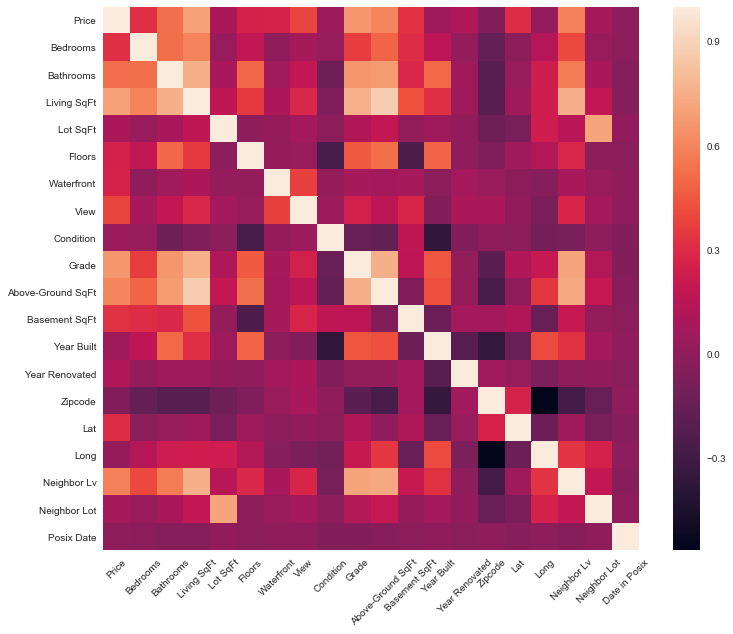

In [11]:
# Creating and displaying the correlation heatmap 
plt.figure(figsize=(12,10))
ax = sns.heatmap(data = map_corr)
plt.xticks(rotation=45)
plt.show()

#### Creating a map displaying the 1000 most expensive homes

In [12]:
# Creating the dataframe for the 1000 most expensive homes
df.sort_values("price", ascending=False)
most_exp_df = df.filter(['price','lat','long', 'zipcode'], axis=1)
most_exp_df = most_exp_df.nlargest(1000, "price")

In [13]:
# Creating the map, focused on the average of our lat/long values in our data
m1 = folium.Map(location=[47.56009, -122.21398],
                zoom_start=9.45, prefer_canvas=True)

# Changing the background map type
folium.TileLayer("cartodbpositron").add_to(m1)

# Marking each home as a point
for index, row in most_exp_df.iterrows():

    # Adding popup text, so clicking each point shows details
    popup_text = "price: {}<br> latitude: {}<br> longitude: {}"
    popup_text = popup_text.format(row["price"],
                                   row["lat"],
                                   row["long"])
    
    # Changing the color based on buckets of cost
    if row["price"] < 2000000:
        color = "#85CB33" #green
    elif row["price"] >= 2000000 and row["price"] < 3000000:
        color = "#F9B700" #yellow
    else:
        color = "#E01A4F" #hot pink

    # Actually adding the markers to the map
    folium.CircleMarker([row['lat'], row['long']],
                        radius=(row["price"]/1000000),
                        color=color,
                        fill=True,
                        popup=popup_text).add_to(m1)

m1

#### Creating a map displaying the 1000 least expensive homes

In [14]:
# Creating the dataframe for the 1000 least expensive homes
least_exp_df = df.filter(['price','lat','long', 'zipcode'], axis=1)
least_exp_df = least_exp_df.nsmallest(1000, "price")

In [15]:
# Creating the map, focused on the average of our lat/long values in our data
m2 = folium.Map(location=[47.56009, -122.21398],
                zoom_start=9.45, prefer_canvas=True)

# Changing the background map type
folium.TileLayer("cartodbpositron").add_to(m2)

# Marking each home as a point
for index, row in least_exp_df.iterrows():

    # Adding popup text, so clicking each point shows details
    popup_text = "price: {}<br> latitude: {}<br> longitude: {}"
    popup_text = popup_text.format(row["price"],
                                   row["lat"],
                                   row["long"])

    # Changing the color based on buckets of cost
    if row["price"] < 100000:
        color = "#39AECC"  # blue
    elif row["price"] >= 100000 and row["price"] < 200000:
        color = "#F9C62C"  # yellow
    else:
        color = "#FF5A30"  # orange
    
    # Actually adding the markers to the map
    folium.CircleMarker([row['lat'], row['long']],
                        radius=(row["price"]/100000),
                        color=color,
                        fill=True,
                        popup=popup_text).add_to(m2)

m2

## Question 2: For the homes where we have data on the last year renovated, does year renovated have a similar impact as age?

In [16]:
# Creating a new dataframe with only these four columns
q2_df = df.filter(["date", "price", "yr_built", "yr_renovated"])

In [17]:
# New column for the year a home was sold, derived from the Date column
q2_df['yr_sold'] = pd.DatetimeIndex(q2_df['date']).year

In [18]:
# New column for age of homes
q2_df['home_age'] = q2_df["yr_sold"] - q2_df["yr_built"]

In [19]:
# Creating a dataframe with all homes that have information on when they were renovated
with_reno_df = q2_df.where(q2_df["yr_renovated"] > 0).dropna()

# Creating a new column just for this 'with renovations' dataframe, 
# showing the number of years since the home was renovated
with_reno_df['since_reno'] = with_reno_df["yr_sold"] - q2_df["yr_renovated"]

# Excluding those renovated after they were sold
with_reno_df = with_reno_df.where(with_reno_df["since_reno"] > 0)

In [20]:
# Creating a dataframe with all homes that do not have information on when they were renovated
without_reno_df = q2_df.where(q2_df["yr_renovated"] == 0).dropna()

# Excluding those built after they were sold
without_reno_df = without_reno_df.where(without_reno_df["home_age"] > 0)

#### Question 2 Data Overview

In [21]:
# Assigning variables to the Home Age column from the dataframe with homes that
# do not have information on when they were renovated, and to the Years Since
# Renovation column from the dataframe with renovated homes
age_col = without_reno_df["home_age"]
since_reno_col = with_reno_df["since_reno"]

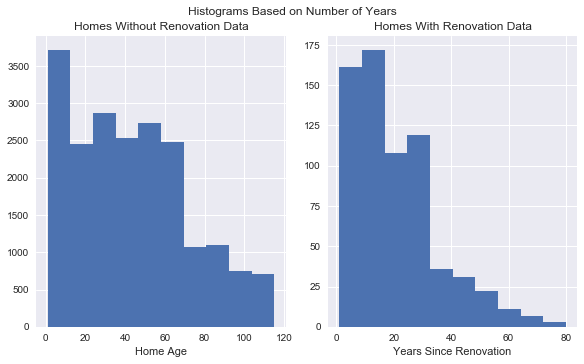

In [22]:
# Creating a histogram to show the frequency of homes at various ages for homes
# without renovation data, and a histogram to show the frequency of homes
# with some number of years since their renovation if they have renovation data
q2f1_1, axes = plt.subplots(1, 2, figsize=(8,5), constrained_layout=True)

q2ax1_0 = age_col.hist(ax=axes[0])
q2ax1_1 = since_reno_col.hist(ax=axes[1])

q2ax1_0.title.set_text("Homes Without Renovation Data")
q2ax1_1.title.set_text("Homes With Renovation Data")

q2ax1_0.set_xlabel("Home Age")
q2ax1_1.set_xlabel("Years Since Renovation")

q2f1_1.suptitle("Histograms Based on Number of Years")
plt.show()

In [23]:
# Creating variables to log the number of years (either home age or years since
# renovation) in order to make the data more normally distributed
age_log = np.log(age_col)
since_reno_log = np.log(since_reno_col)

In [24]:
# Creating new columns in the appropriate dataframes for the log data
without_reno_df["home_age_log"] = age_log
with_reno_df["since_reno_log"] = since_reno_log

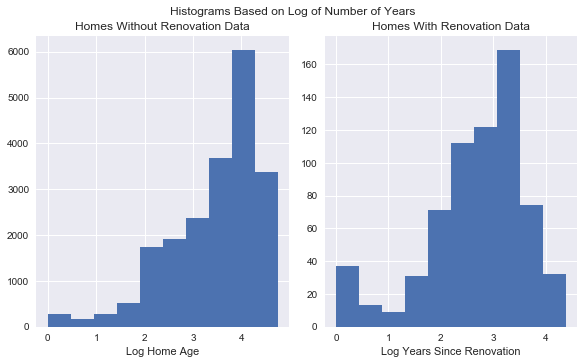

In [25]:
# Creating histograms to show the more normal distributions for the log data
q2f1_2, axes = plt.subplots(1, 2, figsize=(8,5), constrained_layout=True)

q2ax1_2_0 = age_log.hist(ax=axes[0])
q2ax1_2_1 = since_reno_log.hist(ax=axes[1])

q2ax1_2_0.title.set_text("Homes Without Renovation Data")
q2ax1_2_1.title.set_text("Homes With Renovation Data")

q2ax1_2_0.set_xlabel("Log Home Age")
q2ax1_2_1.set_xlabel("Log Years Since Renovation")

q2f1_2.suptitle("Histograms Based on Log of Number of Years")

plt.show()

#### Question 2 Modeling

In [26]:
# Summary of the ordinary least squares reqression comparing price with the log 
# age of homes that do not have renovation data
model_without_reno = ols(formula=('price~home_age_log'), data=without_reno_df).fit()
model_without_reno.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     268.3
Date:                Wed, 08 May 2019   Prob (F-statistic):           6.30e-60
Time:                        11:53:43   Log-Likelihood:            -2.8941e+05
No. Observations:               20410   AIC:                         5.788e+05
Df Residuals:                   20408   BIC:                         5.788e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.731e+05   9136.722     73.668      0.000    6.55e+05    6.91e+05
home_age_log -4.196e+04   2561.624    -16.381      0.000    -4.7e+04   -3.69e+04
==============================================================================
Omnibus:                    16826.051   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           688049.623
Skew:                           3.724   Prob(JB):                         0.00
Kurtosis:                      30.452   Cond. No.                         14.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Summary of the ordinary least squares reqression comparing price with the log 
# number of years since a home has been renovated for homes with renovation data
model_with_reno = ols(formula=('price~since_reno_log'), data=with_reno_df).fit()
model_with_reno.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.148
Date:                Wed, 08 May 2019   Prob (F-statistic):             0.0421
Time:                        11:59:07   Log-Likelihood:                -9918.1
No. Observations:                 670   AIC:                         1.984e+04
Df Residuals:                     668   BIC:                         1.985e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       9.179e+05   7.25e+04     12.666      0.000    7.76e+05    1.06e+06
since_reno_log  -5.21e+04   2.56e+04     -2.037      0.042   -1.02e+05   -1871.331
==============================================================================
Omnibus:                      664.262   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35581.815
Skew:                           4.420   Prob(JB):                         0.00
Kurtosis:                      37.589   Cond. No.                         9.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Question 2 Summary

Unfortunately, there is a chance that the number of years since a home was renovated is statistically insignificant, as shown by the P-Value of .042 (which is close to the popular .05 threshold for significance). We learned that there is little impact on price based on when a home was renovated and it does not act exactly the same as home age.

## Question 3: Does paying more for a house get you more quantity (bedrooms, bathrooms) or quality (condition, grade)?

In [28]:
# Creating a new dataframe with only these seven columns
q3_df = df.filter(["price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "condition", "grade"])

# Adding a new variable for total square footage
q3_df["total_sqft"] = q3_df["sqft_living"] + q3_df["sqft_lot"]

In [29]:
# Creating variables for each column
# Also creating variables to log the continuous variables

price = q3_df["price"]
bedrooms = q3_df["bedrooms"]
bathrooms = q3_df["bathrooms"]
sqft_living = q3_df["sqft_living"]
sqft_lot = q3_df["sqft_lot"]
condition = q3_df["condition"]
grade = q3_df["grade"]
total_sqft = q3_df["total_sqft"]

price_log = np.log(price)
sqft_living_log = np.log(sqft_living)
sqft_lot_log = np.log(sqft_lot)
total_sqft_log = np.log(total_sqft)

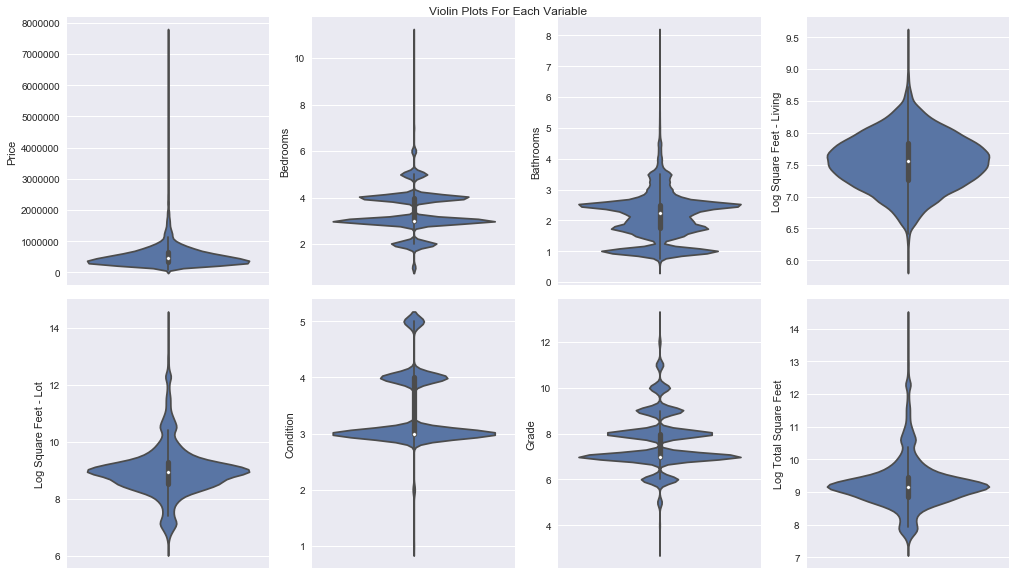

In [30]:
# Creating violinplots (oooh) for each variable
q3f1, axes = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)

q3ax1_0_0 = sns.violinplot(price, orient='v', ax=axes[0,0])
q3ax1_0_1 = sns.violinplot(bedrooms, orient='v', ax=axes[0,1])
q3ax1_0_2 = sns.violinplot(bathrooms, orient='v', ax=axes[0,2])
q3ax1_0_3 = sns.violinplot(sqft_living_log, orient='v', ax=axes[0,3])
q3ax1_1_0 = sns.violinplot(sqft_lot_log, orient='v', ax=axes[1,0])
q3ax1_1_1 = sns.violinplot(condition, orient='v', ax=axes[1,1])
q3ax1_1_2 = sns.violinplot(grade, orient='v', ax=axes[1,2])
q3ax1_1_3 = sns.violinplot(total_sqft_log, orient='v', ax=axes[1,3])

q3ax1_0_0.set_ylabel("Price")
q3ax1_0_1.set_ylabel("Bedrooms")
q3ax1_0_2.set_ylabel("Bathrooms")
q3ax1_0_3.set_ylabel("Log Square Feet - Living")
q3ax1_1_0.set_ylabel("Log Square Feet - Lot")
q3ax1_1_1.set_ylabel("Condition")
q3ax1_1_2.set_ylabel("Grade")
q3ax1_1_3.set_ylabel("Log Total Square Feet")

q3f1.suptitle("Violin Plots For Each Variable")

plt.show()

#### Splitting data frame into four equal parts, based on quartiles

In [31]:
# Sorting and qcutting in order to arrive at ranges for quartiles
q3_df = q3_df.sort_values(by="price")
pd.qcut(q3_df["price"], 4).value_counts()

(322000.0, 450000.0]     5445
(77999.999, 322000.0]    5406
(450000.0, 645000.0]     5374
(645000.0, 7700000.0]    5371
Name: price, dtype: int64

In [32]:
# Creating a new Quartile column
q3_df.loc[q3_df["price"] <= 323000, "quartile"] = 1
q3_df.loc[q3_df["price"].between(322000.1, 450000.0, inclusive=True), "quartile"] = 2
q3_df.loc[q3_df["price"].between(450000.1, 645000.0, inclusive=True), "quartile"] = 3
q3_df.loc[q3_df["price"] > 645000, "quartile"] = 4

#### Creating and melting quality and quantity columns

In [33]:
quantity_df = q3_df.filter(["price", "bedrooms", "bathrooms", "quartile"])

# Melting quantity columns (bedrooms, bathrooms and total_sqft) into one column
melted_quantity_df = pd.melt(quantity_df,
                            id_vars=["price", "quartile"],
                            var_name="quantity")

In [34]:
quality_df = q3_df.filter(["price", "condition", "grade", "quartile"])

# Melting quality columns (condition, grade) into one column
melted_quality_df = pd.melt(quality_df,
                            id_vars=["price", "quartile"],
                            var_name="quality")

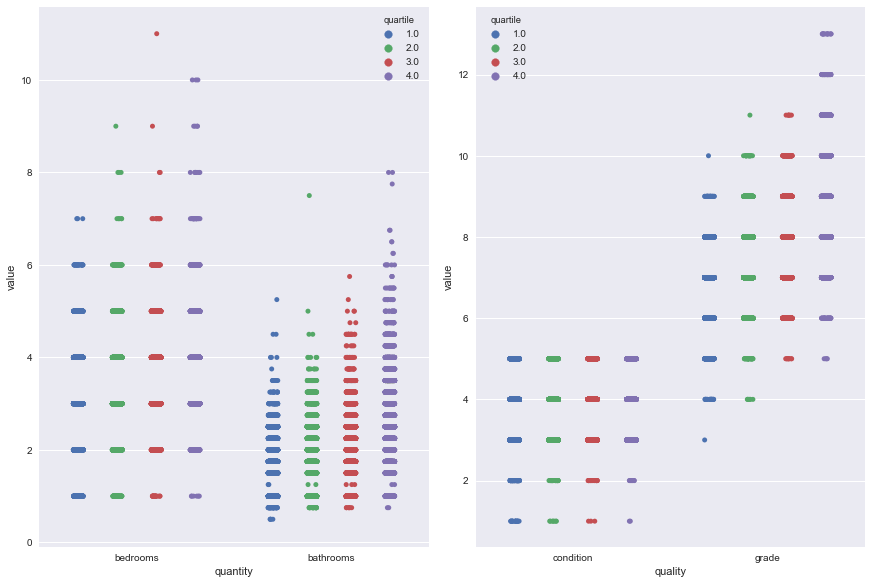

In [35]:
q3f3, axes = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

q3ax2_0 = sns.stripplot(x="quantity", 
                      y="value", 
                      hue="quartile", 
                      data=melted_quantity_df,
                      dodge=True,
                      ax=axes[0])
q3ax2_1 = sns.stripplot(x="quality", 
                      y="value", 
                      hue="quartile", 
                      data=melted_quality_df,
                      dodge=True,
                      ax=axes[1])

In [36]:
# Creating a dataframe for quantity variables, using the log of total square feet
quantity_df = pd.DataFrame()
quantity_df["price"] = price
quantity_df["bedrooms"] = bedrooms
quantity_df["bathrooms"] = bathrooms
quantity_df["total_sqft_log"] = total_sqft_log

# Modeling our quantity variables against target Price
quantity_model = ols(formula=('price~bedrooms+bathrooms+total_sqft_log'), data=quantity_df).fit()
quantity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     2977.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        11:53:50   Log-Likelihood:            -3.0364e+05
No. Observations:               21596   AIC:                         6.073e+05
Df Residuals:                   21592   BIC:                         6.073e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.297e+05   2.53e+04    -20.918      0.000   -5.79e+05    -4.8e+05
bedrooms        1.225e+04   2775.556      4.413      0.000    6808.683    1.77e+04
bathrooms       2.327e+05   3229.213     72.056      0.000    2.26e+05    2.39e+05
total_sqft_log  5.796e+04   2805.669     20.660      0.000    5.25e+04    6.35e+04
==============================================================================
Omnibus:                    17293.463   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           898572.911
Skew:                           3.460   Prob(JB):                         0.00
Kurtosis:                      33.833   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Creating a dataframe for quality variables
quality_df = q3_df[["price", "condition", "grade"]]

# Modeling our quality variables against target Price
quality_model = ols(formula=('price~condition+grade'), data=quality_df).fit()
quality_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     9367.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        11:53:50   Log-Likelihood:            -3.0063e+05
No. Observations:               21596   AIC:                         6.013e+05
Df Residuals:                   21593   BIC:                         6.013e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.374e+06   1.67e+04    -82.474      0.000   -1.41e+06   -1.34e+06
condition   7.742e+04   2843.254     27.230      0.000    7.18e+04     8.3e+04
grade       2.155e+05   1576.393    136.683      0.000    2.12e+05    2.19e+05
==============================================================================
Omnibus:                    20147.765   Durbin-Watson:                   0.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2218082.130
Skew:                           4.152   Prob(JB):                         0.00
Kurtosis:                      51.949   Cond. No.                         78.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""